## 0. Get data

### 0.1 Install data from kaggle

In [1]:
import os

!mkdir -p /root/.kaggle

os.replace('/root/kaggle.json', '/root/.kaggle/kaggle.json')

!chmod 600 /root/.kaggle/kaggle.json

# ---------------------------------------------------

import kaggle

import zipfile
from pathlib import Path

import pandas as pd
import numpy as np
from math import *

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import PIL
from PIL import Image, ImageOps, ImageFilter
import cv2
import imutils
from tqdm.auto import tqdm
from timeit import default_timer as timer
import random

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import torchvision
from torchvision import transforms

from sklearn.model_selection import train_test_split

from typing import Tuple, List, Dict

In [2]:
!pwd
os.mkdir('data')
os.chdir('/content/data')

!kaggle datasets download -d jessicali9530/celeba-dataset

os.chdir('/content')
!pwd

data_dir = Path('data')
zipped_dataset_name = 'celeba-dataset.zip'
with zipfile.ZipFile(data_dir / zipped_dataset_name, 'r') as zip_ref:
  zip_ref.extractall(data_dir)

os.remove(data_dir / zipped_dataset_name)

/content
100% 1.33G/1.33G [00:34<00:00, 41.2MB/s]
100% 1.33G/1.33G [00:34<00:00, 41.0MB/s]
/content


### 0.3 Get DataFrames

In [3]:
df_landmarks = pd.read_csv(data_dir / 'list_landmarks_align_celeba.csv')

In [4]:
images_dir = data_dir / "img_align_celeba" / "img_align_celeba"

print(f'There are {df_landmarks.isna().sum().sum()} missing values in df_landmarks')
print(f'There is {len(os.listdir(images_dir))} images in data_dir / img_align_celeba / img_align_celeba')
print(f'Shape of df_landmarks is {df_landmarks.shape}')

There are 0 missing values in df_landmarks
There is 202599 images in data_dir / img_align_celeba / img_align_celeba
Shape of df_landmarks is (202599, 11)


### 0.4 Device agnostic

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 1. Data Exploration

In [6]:
df_landmarks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   image_id      202599 non-null  object
 1   lefteye_x     202599 non-null  int64 
 2   lefteye_y     202599 non-null  int64 
 3   righteye_x    202599 non-null  int64 
 4   righteye_y    202599 non-null  int64 
 5   nose_x        202599 non-null  int64 
 6   nose_y        202599 non-null  int64 
 7   leftmouth_x   202599 non-null  int64 
 8   leftmouth_y   202599 non-null  int64 
 9   rightmouth_x  202599 non-null  int64 
 10  rightmouth_y  202599 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 17.0+ MB


In [7]:
df_landmarks.describe()

lefteye_x      lefteye_y     righteye_x     righteye_y  \
count  202599.000000  202599.000000  202599.000000  202599.000000   
mean       69.353867     111.197982     107.644031     111.161600   
std         1.717952       1.129284       1.690252       1.169229   
min        56.000000      98.000000      90.000000      95.000000   
25%        68.000000     111.000000     107.000000     111.000000   
50%        69.000000     111.000000     108.000000     111.000000   
75%        70.000000     112.000000     109.000000     112.000000   
max        88.000000     129.000000     124.000000     122.000000   

              nose_x         nose_y    leftmouth_x    leftmouth_y  \
count  202599.000000  202599.000000  202599.000000  202599.000000   
mean       88.063140     135.102024      71.247459     152.113011   
std         6.647733       4.245078       3.168011       1.799343   
min        57.000000      93.000000      57.000000     116.000000   
25%        84.000000     133.000000      69.000000     151.000000   
50%        88.000000     135.000000      72.000000     152.000000   
75%        92.000000     138.000000      73.000000     153.000000   
max       121.000000     156.000000      90.000000     174.000000   

        rightmouth_x   rightmouth_y  
count  202599.000000  202599.000000  
mean      105.586429     152.194660  
std         3.233125       1.752368  
min        82.000000     114.000000  
25%       103.000000     151.000000  
50%       105.000000     152.000000  
75%       108.000000     153.000000  
max       120.000000     173.000000

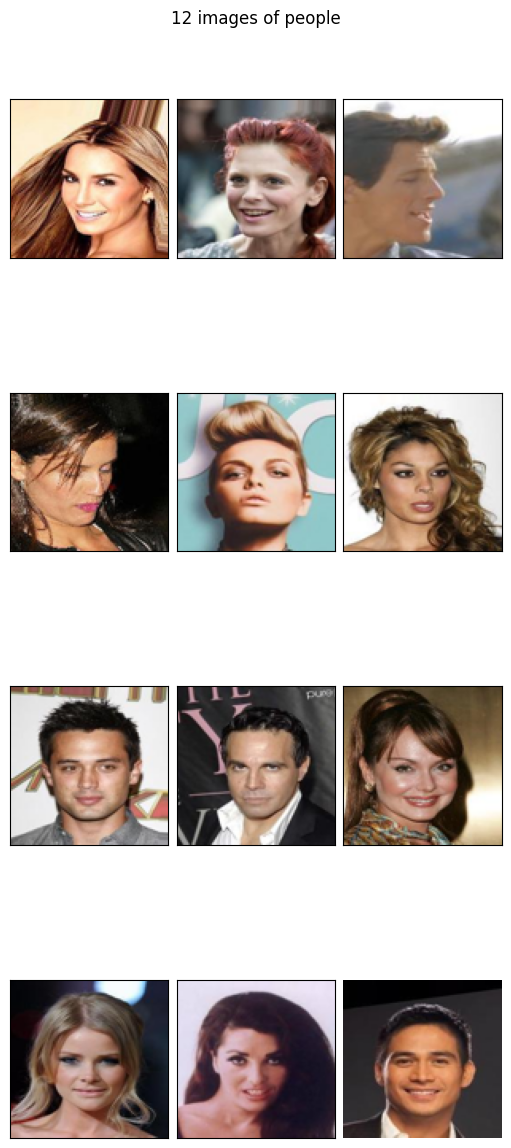

In [8]:
def plot_some_images(images_index):
  img_size = (100,100)

  fig, axs = plt.subplots(nrows=len(images_index)//3, ncols=3, figsize=(5, len(images_index)), constrained_layout=True)

  for i, ax in enumerate(axs.ravel()):
    if i > len(images_index) - 1:
      ax.axis(False)
      continue
    else:
      try:
        image = Image.open(images_dir / images_index[i]).resize(img_size)

        ax.imshow(image)
      except:
        print(f'There is no image with index {images_index[i]}')

    ax.set_xticks([])
    ax.set_yticks([])

  #plt.subplots_adjust(wspace=0, hspace=0)
  plt.suptitle(f'{len(images_index)} images of people')

  plt.axis(False)

plot_some_images(df_landmarks['image_id'][:12])

**Summary**:

The data is good.

There are many outliers as a function of Euclidean distance, but all of them (or most of them) are due to the distance to the camera in the image.

There is not a single image where the distance between lips, eyes, or anything else is greater than or nearly the size of the image.

## 2. Data Preparation

In [100]:
df_landmarks = df_landmarks_copy.copy()

images_data_size = 15000

# Original image shape
x_org = 178
y_org = 218

# New image dimensions
x_ = 100
image_size_ratio = x_org / y_org
y_ = int(image_size_ratio * x_)

# Image Sizes
original_image_size = (x_org, y_org)
image_size_training = (224, 224)

In [101]:
df_landmarks = df_landmarks.iloc[:images_data_size]

### 2.1 Read images

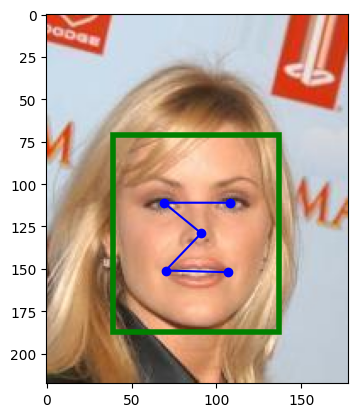

In [102]:
def array_of_image(index: str,
                   size: Tuple[int, int] = image_size_training,
                   images_path: Path = images_dir):

  path = images_path / index

  image = Image.open(path).resize(size)
  image_array = np.asarray(image)

  return image_array

def plot_image_with_box(index: str,
                        df: pd.DataFrame = df_landmarks,
                        size: Tuple[int, int] = original_image_size):

  image = array_of_image(index, size)
  points = df.set_index('image_id').loc[index, :]

  le_x, le_y, re_x, re_y = points[0], points[1], points[2], points[3]
  n_x, n_y = points[4], points[5]
  lm_x, lm_y, rm_x, rm_y = points[6], points[7], points[8], points[9]

  fig, ax = plt.subplots()

  ax.imshow(image)
  ax.plot([re_x, le_x, n_x, lm_x, rm_x], [re_y, le_y, n_y, lm_y, rm_y], 'bo-')

  width = abs(le_x-rm_x-60)
  height = abs(le_y-rm_y-75)
  rect = patches.Rectangle((le_x-30, le_y-40), width, height, linewidth=4, edgecolor='g', facecolor='none')

  ax.add_patch(rect)

plot_image_with_box('000029.jpg')

In [103]:
def train_test_xy_generator(data: pd.DataFrame = df_landmarks):
  df = data.copy()
  df = df.set_index('image_id')

  x_, y_ = [], []

  for index, target in df.iterrows():
      im = Image.open(images_dir / index).convert('RGB')

      x_.append(im)
      y_.append(target.to_list())

  X_train, X_test, y_train, y_test = train_test_split(x_, y_, test_size=0.2, random_state=42)

  X_y_train = [(x,y) for x, y in zip(X_train, y_train)]
  X_y_test = [(x,y) for x, y in zip(X_test, y_test)]

  return X_y_train, X_y_test

In [104]:
X_y_train, X_y_test = train_test_xy_generator()

## 3. Image preprocessing

In [169]:
class Transforms():
  def __init__(self, trans_type=None):
    self.trans_type = trans_type

    self.facecascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

  def crop_face(self, image, landmarks=None):
    imgtest = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    image_array = np.array(imgtest, "uint8")

    faces = self.facecascade.detectMultiScale(imgtest,
        scaleFactor=1.1, minNeighbors=3)

    if len(faces) != 1:
      print(f'---Face is not detected---\n')
      return image, landmarks

    for (x_, y_, w, h) in faces:
      image_array = image_array[y_: y_ + h, x_: x_ + w]

      if landmarks is not None:
        landmarks[:, 0] -= x_
        landmarks[:, 1] -= y_

      im = Image.fromarray(image_array)

    if self.trans_type == 'fin_test':
      img_size = im.size
      return im, x_, y_, w, h, img_size

    return im, landmarks

  def shift_image(self, image, landmarks):
    """Shifts an image and landmarks"""
    if landmarks is not None:
      # Calculate max in min values for coordinates ( so it won't hit the border )
      possible_error = 10

      max_x = image.width - np.max(landmarks[:,0]) - possible_error
      min_x = -np.min(landmarks[:,0]) + possible_error

      max_y = image.height - np.max(landmarks[:,1]) - possible_error
      min_y = -np.min(landmarks[:,1]) + possible_error

      # Random values to shift image and landmarks
      x_shift = random.randint(min_x, max_x)
      y_shift = random.randint(min_y, max_y)

      landmarks[:,0] += x_shift
      landmarks[:,1] += y_shift

    else:
      x_shift = random.randint(-20, 20)
      y_shift = random.randint(-20, 20)

    # Define the affine transformation matrix
    matrix = (1, 0, -x_shift, 0, 1, -y_shift)

    # Apply the transformation
    shifted_image = image.transform(image.size, Image.AFFINE, matrix)

    return shifted_image, landmarks

  def resize(self, image, landmarks=None, new_size=(224,224)):
    """Resizes an image"""
    if landmarks is not None:

      x_old, y_old = image.size

      x_new, y_new = new_size

      x_ratio = x_new / x_old
      y_ratio = y_new / y_old

      landmarks[:, 0] = landmarks[:, 0] * x_ratio
      landmarks[:, 1] = landmarks[:, 1] * y_ratio

    resized_image = TF.resize(image, new_size)
    return resized_image, landmarks

  def color_jitter(self, image, landmarks):
    """Applies color jitter to an image"""

    color_jitter = transforms.ColorJitter(brightness=random.randint(0,3)/10,
                                          contrast=random.randint(0,3)/10,
                                          saturation=random.randint(0,3)/10,
                                          hue=random.uniform(0,0.5))
    colored_image = color_jitter(image)
    return colored_image, landmarks

  def rotate(self, image, landmarks, angle, center=(112, 112)):
    """Rotates an image and its landmarks around a given center.

    Args:
      image: A PIL.Image object.
      landmarks: A list of landmarks, represented as a list of (x, y) coordinates.
      angle: The rotation angle in degrees.
      center: The center of rotation, represented as a (x, y) coordinate.

    Returns:
      A rotated image and a list of rotated landmarks.
    """

    # Calculate the rotation matrix.
    angle_rad = radians(angle)
    transformation_matrix = torch.tensor([
      [cos(angle_rad), -sin(angle_rad)],
      [sin(angle_rad), cos(angle_rad)]
    ])

    landmarks = torch.from_numpy(landmarks).type(torch.float)

    # Translate the landmarks to the center of rotation.
    translated_landmarks = landmarks.clone()
    translated_landmarks[:,0] -= center[0]
    translated_landmarks[:,1] -= center[1]

    # Rotate the landmarks around the center of rotation.
    rotated_landmarks = torch.matmul(translated_landmarks, transformation_matrix)

    # Translate the landmarks back to their original position.
    rotated_landmarks[:,0] += center[0]
    rotated_landmarks[:,1] += center[1]

    # Rotate the image.
    rotated_image = TF.rotate(image, angle)

    return rotated_image, rotated_landmarks.round().numpy()

  def __call__(self, image, landmarks=None, resize_size=(224,224)):
    # Use all the transforms
    if self.trans_type == 'fin_test':
      image, *cropped_face = self.crop_face(image)
      image, landmarks = self.resize(image, landmarks, resize_size)

    else:
      image, landmarks = self.crop_face(image, landmarks)
      image, landmarks = self.resize(image, landmarks, resize_size)

      if self.trans_type != 'test':
        # image, landmarks = self.shift_image(image, landmarks)
        # image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, random.randint(-20,20), center=(image.width / 2, image.height / 2))

    image = image.convert('L')
    image = TF.to_tensor(image)
    image = TF.normalize(image, mean=[0.5], std=[0.5])

    if self.trans_type == 'fin_test':
      return image, cropped_face

    if landmarks is None:
      return image

    return image, landmarks.flatten()


In [106]:
class CustomLandmarksDataset(Dataset):
  def __init__(self, data, transform=None):
    self.data = data
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image, landmarks = self.data[idx]

    if self.transform:
      image, landmarks = self.transform(image, np.array(landmarks).reshape(-1, 2))

    return image, landmarks

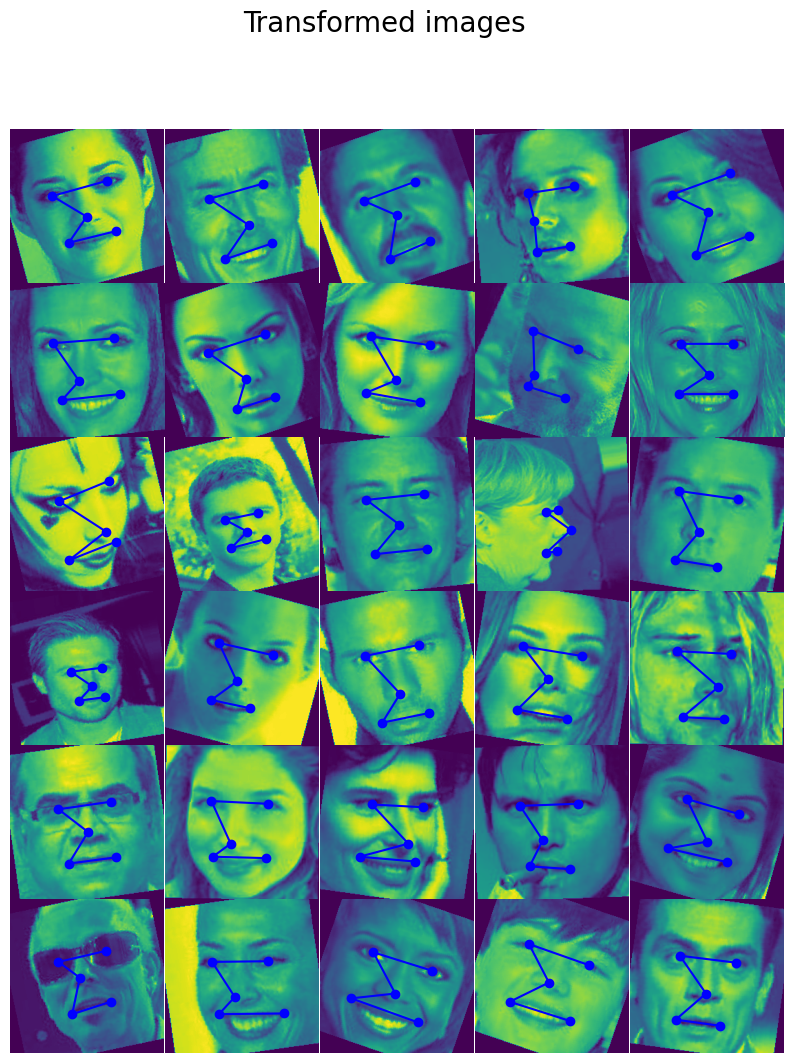

In [107]:
temp_var = CustomLandmarksDataset(X_y_train[:50], transform=Transforms())
images = [temp_var[i] for i in range(30)]

# Set up the figure
fig, axes = plt.subplots(6, 5, figsize=(10, 12))
plt.subplots_adjust(wspace=0, hspace=0)

# Iterate through the axes and images, and plot each image
for ax, image_lmark in zip(axes.ravel(), images):
    image = image_lmark[0]
    landm = image_lmark[1]

    le_x, le_y, re_x, re_y = landm[0], landm[1], landm[2], landm[3]
    n_x, n_y = landm[4], landm[5]
    lm_x, lm_y, rm_x, rm_y = landm[6], landm[7], landm[8], landm[9]

    ax.imshow(image.permute(1,2,0))
    ax.plot([re_x, le_x, n_x, lm_x, rm_x], [re_y, le_y, n_y, lm_y, rm_y], 'bo-')

    ax.axis('off')

# Show the plot
plt.suptitle('Transformed images', fontsize=20)
plt.show()

In [108]:
BATCH_SIZE = 32

train_data = CustomLandmarksDataset(X_y_train, transform=Transforms())
test_data = CustomLandmarksDataset(X_y_test, transform=Transforms('test'))

def collate_fn(batch):
    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    labels = torch.tensor(labels)
    return images, labels

train_dataloader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn)

## 4. Model

In [109]:
class FaceLandmarksModel(nn.Module):
    def __init__(self,num_classes=10):
        super().__init__()

        self.model=torchvision.models.resnet18()

        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        x=self.model(x)
        return x

### 4.1 Model training

In [110]:
def metric(preds, targets):
  """Calculates the mean absolute error for multiple outputs.

  Args:
    preds: A tensor of predicted values, with shape (batch_size, num_outputs).
    targets: A tensor of actual values, with shape (batch_size, num_outputs).

  Returns:
    A tensor of the mean absolute error, with shape (1,).
  """

  # Calculate the difference between the predicted and actual values.
  diffs = preds - targets

  # Take the absolute value of the differences.
  abs_diffs = torch.abs(diffs)

  # Average the absolute values of the differences for each sample.
  mae_per_sample = abs_diffs.sum(dim=1) / abs_diffs.shape[1]

  # Average the results from step 3 across all samples.
  mae = mae_per_sample.mean()

  return mae

In [111]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

INPUT_LAYERS = 1 # Number of colors
HIDDEN_LAYERS = 10 # Hidden layers
OUTPUT_LAYERS = len(X_y_train[0][1]) # Number of features to predict

# model = EnhancedFaceDetectionModel(INPUT_LAYERS, HIDDEN_LAYERS, OUTPUT_LAYERS).to(device)
model = FaceLandmarksModel(OUTPUT_LAYERS).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model_save_path = '/content/myModel1.pth'

scheduler = StepLR(optimizer=optimizer,
                   step_size=5,
                   gamma=0.1,
                   last_epoch=-1,
                   verbose=True)

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

NUM_EPOCHS = 15
loss_min = np.inf

start_time = timer()
for epoch in tqdm(range(NUM_EPOCHS)):
  model.train()

  train_loss = 0

  list_of_mae_train = 0

  for X_train, y_train in train_dataloader:
    X_train = torch.stack(X_train).to(device)
    y_train = y_train.type(torch.float32).to(device)

    y_pred = model(X_train)

    loss = loss_fn(y_pred, y_train)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    list_of_mae_train += metric(y_pred, y_train)

  train_loss = train_loss / len(train_dataloader)
  train_mae = list_of_mae_train.cpu() / len(train_dataloader)

  test_loss = 0

  list_of_mae_test = 0

  model.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      X_test = torch.stack(X_test).to(device)
      y_test = y_test.type(torch.float32).to(device)

      test_pred = model(X_test)

      loss = loss_fn(test_pred, y_test)
      test_loss += loss.item()

      list_of_mae_test += metric(test_pred, y_test)

  test_loss = test_loss / len(test_dataloader)
  test_mae = list_of_mae_test.cpu() / len(test_dataloader)

  scheduler.step()

  if test_loss < loss_min:
    loss_min = test_loss
    torch.save(model.state_dict(), model_save_path)
    best_epoch = epoch
    print(f'Epoch: {epoch+1} | Model loss is {test_loss} | Save model to "{model_save_path}".')

  results["train_loss"].append(train_loss)
  results["train_acc"].append(train_mae)
  results["test_loss"].append(test_loss)
  results["test_acc"].append(test_mae)

  print(f'Epoch: {epoch+1} | Train Loss: {train_loss:.5f} | Train MAE: {train_mae:.2f} | Test loss: {test_loss:.5f} | Test MAE: {test_mae:.2f}')

end_time = timer()

print(f'Training process took {end_time - start_time} seconds')

Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/15 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 1 | Model loss is 317.32030795482876 | Save model to "/content/myModel1.pth".
Epoch: 1 | Train Loss: 2554.40079 | Train MAE: 31.68 | Test loss: 317.32031 | Test MAE: 7.57
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 2 | Model loss is 287.9184638895887 | Save model to "/content/myModel1.pth".
Epoch: 2 | Train Loss: 158.79459 | Train MAE: 7.75 | Test loss: 287.91846 | Test MAE: 6.29
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 3 | Train Loss: 116.51618 | Train MAE: 5.83 | Test loss: 316.46955 | Test MAE: 7.65
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 4 | Model loss is 272.76266572830525 | Save model to "/content/myModel1.pth".
Epoch: 4 | Train Loss: 111.73509 | Train MAE: 5.58 | Test loss: 272.76267 | Test MAE: 5.53
Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 5 | Model loss is 268.03291497331986 | Save model to "/content/myModel1.pth".
Epoch: 5 | Train Loss: 99.28082 | Train MAE: 

In [ ]:
def plot_loss_curves(resultm, k = best_epoch):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = [x.detach().numpy() for x in results["train_acc"]]
    test_accuracy = results["test_acc"]
    epochs = list(map(str,range(1,len(results["train_loss"])+1)))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.ylim((0,1000))
    plt.axvline(x=k, c='black')
    plt.annotate('Model is taken here', xy=(k,500))

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_mae")
    plt.plot(epochs, test_accuracy, label="test_mae")
    plt.title("Mean Absolute Error")
    plt.xlabel("Epochs")
    plt.legend()
    plt.axvline(x=k, c='black')
    plt.annotate('Model is taken here', xy=(k,30))

plot_loss_curves(results, k = best_epoch)

In [ ]:
model_path = 'myModel1.pth'

# model = EnhancedFaceDetectionModel(INPUT_LAYERS, HIDDEN_LAYERS, OUTPUT_LAYERS)
model = FaceLandmarksModel(OUTPUT_LAYERS)

model.load_state_dict(torch.load(f'/content/{model_path}'))

<All keys matched successfully>

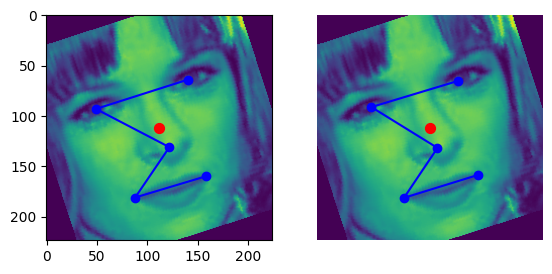

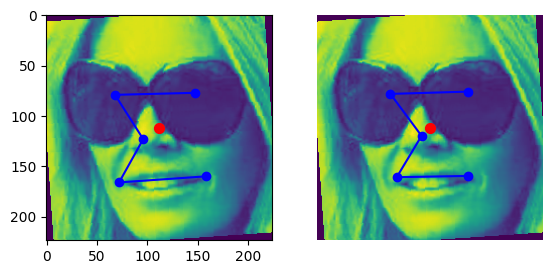

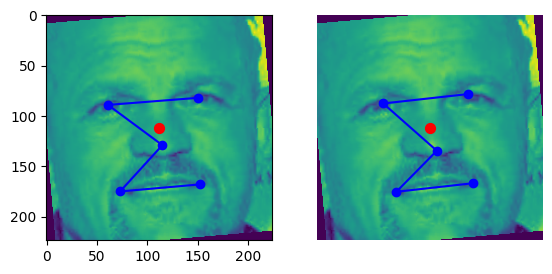

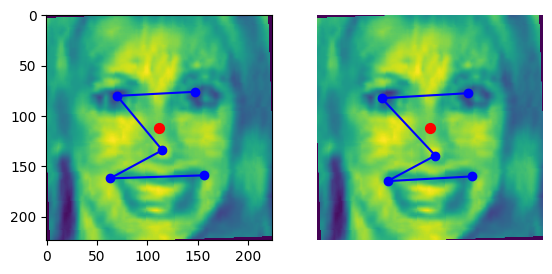

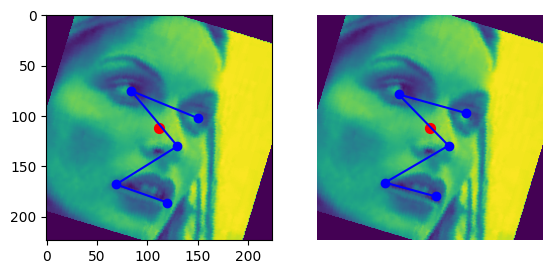

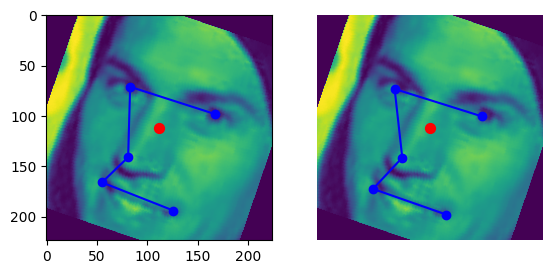

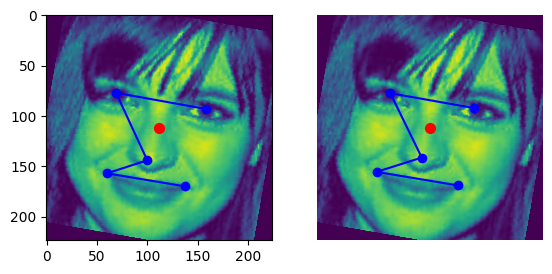

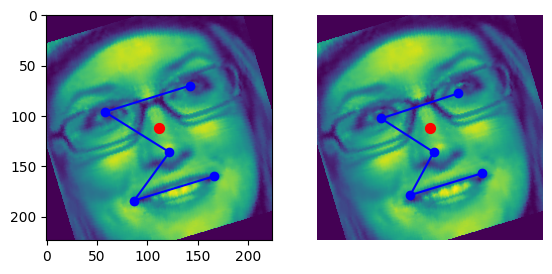

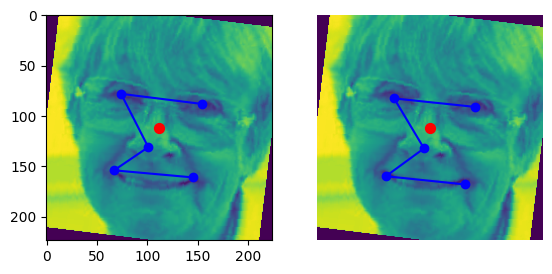

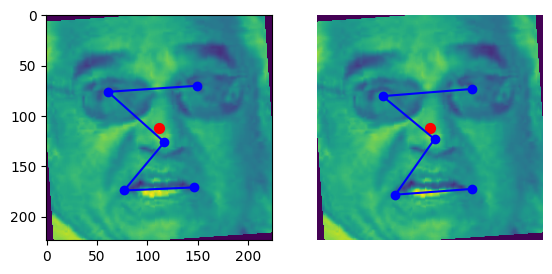

In [151]:
def pred_train_plots(model = model.to('cpu'), start=90, end=100, test_train = 'train'):
  options = {'train':X_y_train, 'test':X_y_test}

  temp_var = CustomLandmarksDataset(options[test_train][:end], transform=Transforms())

  for i in range(start, end):
    image_lmark = temp_var[i]

    image = image_lmark[0]
    landm = image_lmark[1]

    le_x, le_y, re_x, re_y = landm[0], landm[1], landm[2], landm[3]
    n_x, n_y = landm[4], landm[5]
    lm_x, lm_y, rm_x, rm_y = landm[6], landm[7], landm[8], landm[9]

    fig, axs = plt.subplots(1, 2)

    axs[0].imshow(image.permute(1,2,0))
    axs[0].scatter(112, 112, s=50, c = 'r')
    axs[0].plot([re_x, le_x, n_x, lm_x, rm_x], [re_y, le_y, n_y, lm_y, rm_y], 'bo-')

    model.eval()
    with torch.inference_mode():
      image_pred = model(image.unsqueeze(0))

    points = image_pred[0]

    le_x, le_y, re_x, re_y = points[0], points[1], points[2], points[3]
    n_x, n_y = points[4], points[5]
    lm_x, lm_y, rm_x, rm_y = points[6], points[7], points[8], points[9]

    axs[1].imshow(image.permute(1,2,0))
    axs[1].scatter(112, 112, s=50, c = 'r')
    axs[1].plot([re_x, le_x, n_x, lm_x, rm_x], [re_y, le_y, n_y, lm_y, rm_y], 'bo-')

    plt.axis('off')
    plt.show()

pred_train_plots(test_train='test')

In [152]:
def pred_and_plot_image_with_box(image_path: str,
                                  transform = Transforms(),
                                  size: Tuple[int, int] = original_image_size,
                                  model: nn.Module = model.to('cpu')):

  image = Image.open(image_path).resize((224,224))

  if transform:
    target_image = transform(image)

  model.eval()
  with torch.inference_mode():
    target_image = target_image.unsqueeze(0)

    target_image_pred = model(target_image)

  #x_ratio = 1 * (original_image_size[0] / image_size_training[0])
  #y_ratio = 1 * (original_image_size[1] / image_size_training[1])
  x_ratio, y_ratio = 1, 1

  points = target_image_pred[0]
  print('Points: ', points)

  le_x, le_y, re_x, re_y = int(points[0] * x_ratio), int(points[1] * y_ratio), int(points[2] * x_ratio), int(points[3] * y_ratio)
  n_x, n_y = int(points[4] * x_ratio), int(points[5] * y_ratio)
  lm_x, lm_y, rm_x, rm_y = int(points[6] * x_ratio), int(points[7] * y_ratio), int(points[8] * x_ratio), int(points[9] * y_ratio)

  fig, axs = plt.subplots(1, 2)

  axs[0].imshow(image)

  axs[1].imshow(target_image.squeeze(0).permute(1,2,0))
  axs[1].scatter([re_x, le_x, n_x, lm_x, rm_x], [re_y, le_y, n_y, lm_y, rm_y], s=150, c='r', alpha=0.5, marker='s')

  plt.show()

Points:  tensor([ 71.0958,  88.6400, 146.6780,  86.7459, 115.9928, 132.2777,  76.6526,
        169.1684, 143.0417, 167.4078])


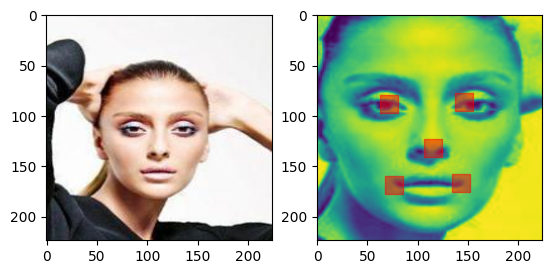

In [153]:
pred_and_plot_image_with_box(image_path='/content/data/img_align_celeba/img_align_celeba/051574.jpg', transform=Transforms('test'), size=original_image_size, model = model.to('cpu'))

Points:  tensor([ 68.8673,  82.6009, 162.0299,  83.5136,  98.8433, 141.5730,  74.4094,
        180.9962, 157.7095, 183.3540])


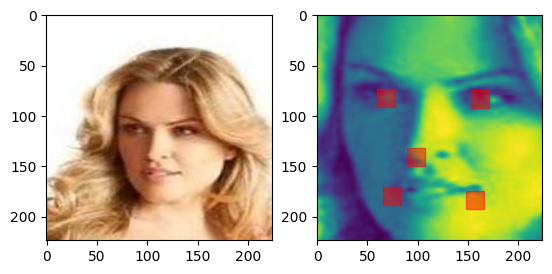

Points:  tensor([ 70.3830,  84.3230, 151.6440,  84.1183, 113.1228, 132.4726,  73.1041,
        167.2845, 148.3706, 167.2583])


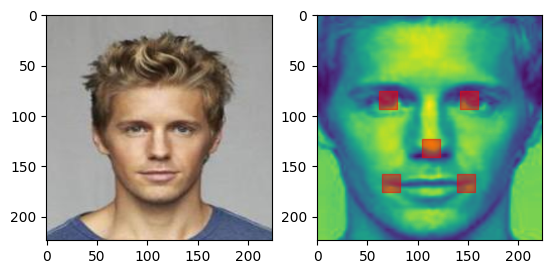

Points:  tensor([ 76.4881,  85.6045, 159.4487,  85.0827, 128.0239, 134.2052,  74.1629,
        163.8132, 160.3683, 162.7395])


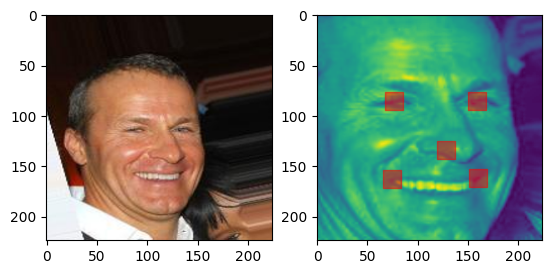

Points:  tensor([ 71.5152,  90.3988, 162.4900,  89.3131, 118.6711, 147.8172,  70.8561,
        173.6933, 164.7228, 172.9764])


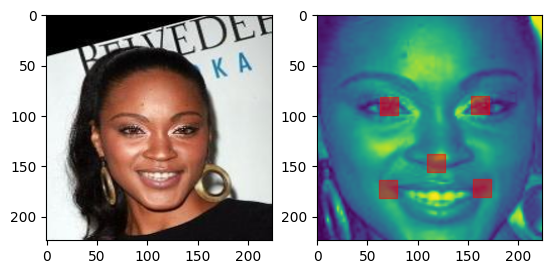

Points:  tensor([ 72.7672,  85.3287, 149.4794,  83.4050, 115.9757, 128.0080,  77.2175,
        164.4338, 147.8319, 162.6387])


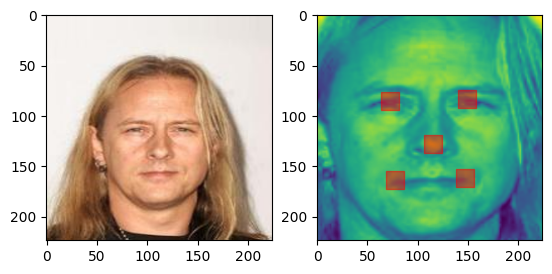

---Face is not detected---

Points:  tensor([ 88.0476, 113.5935, 133.6014, 117.8324, 108.9082, 139.5472,  84.8925,
        150.6047, 127.9749, 154.8407])


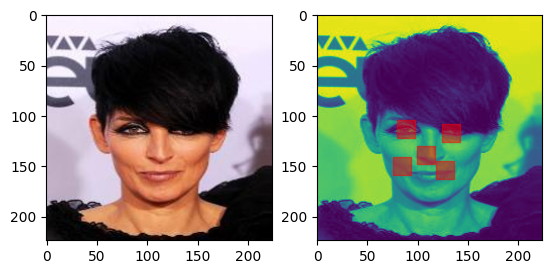

Points:  tensor([ 75.1716,  85.4824, 156.4008,  85.3458, 112.5786, 132.8902,  74.0031,
        160.1891, 158.7030, 160.1646])


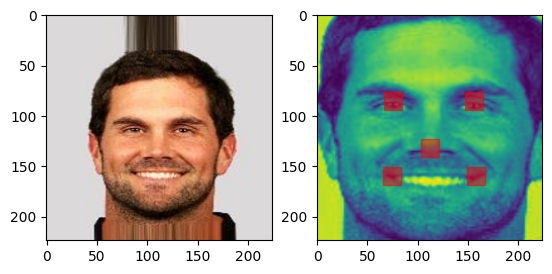

Points:  tensor([ 69.5512,  81.1704, 158.8248,  81.0439, 121.9774, 137.0154,  65.2235,
        158.1611, 161.6576, 157.8571])


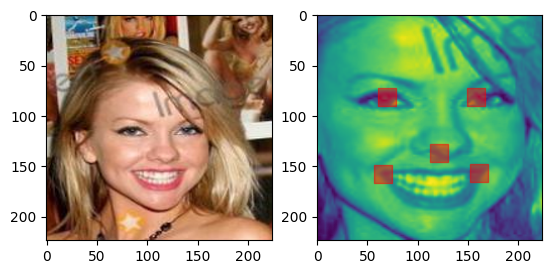

Points:  tensor([ 71.8551,  89.4826, 151.0390,  83.8070, 141.2755, 133.8333,  82.4923,
        183.3087, 147.4479, 176.4077])


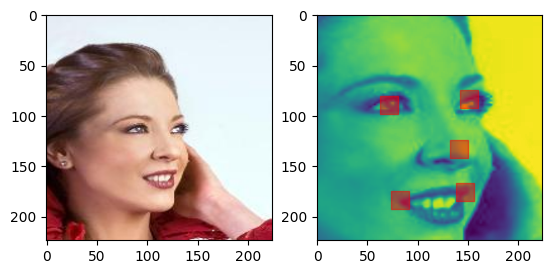

Points:  tensor([ 66.2997,  82.1723, 157.6862,  83.4898, 110.7567, 143.8798,  67.3626,
        172.5817, 153.9886, 174.2049])


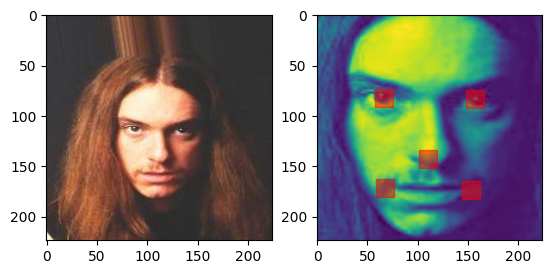

In [154]:
for i in range(30,40,1):
  pred_and_plot_image_with_box(image_path=f'/content/data/img_align_celeba/img_align_celeba/1002{i}.jpg', transform=Transforms('test'), size=original_image_size, model = model.to('cpu'))

In [185]:
def fin_test_pred_plot(image_path, transform=Transforms('fin_test'), model=model.to('cpu')):

    image = Image.open(image_path)

    if transform:
        target_image, cropped_face = transform(image)

    if len(cropped_face) != 1:
      x_, y_, w, h, img_size = cropped_face
    else:
      return 'There is no face on this image.'

    model.eval()
    with torch.inference_mode():
        target_image = target_image.unsqueeze(0)

        target_image_pred = model(target_image)

    points = np.array(target_image_pred[0]).reshape(-1, 2)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(image)
    axs[0].set_title("Original Image")

    axs[1].imshow(target_image.squeeze(0).permute(1, 2, 0))
    axs[1].scatter(points[:, 0], points[:, 1], c='r', marker='s', alpha=0.5, s=100)
    axs[1].set_title("Predicted Points on Cropped Face")

    points[:, 0] = points[:, 0] * w/224 + x_
    points[:, 1] = points[:, 1] * h/224 + y_

    axs[2].imshow(image)
    axs[2].scatter(points[:, 0], points[:, 1], c='r', marker='s', alpha=0.5, s=100)
    axs[2].set_title("Predicted Points on Original Image")

    for ax in axs:
        ax.axis('off')

    plt.show()


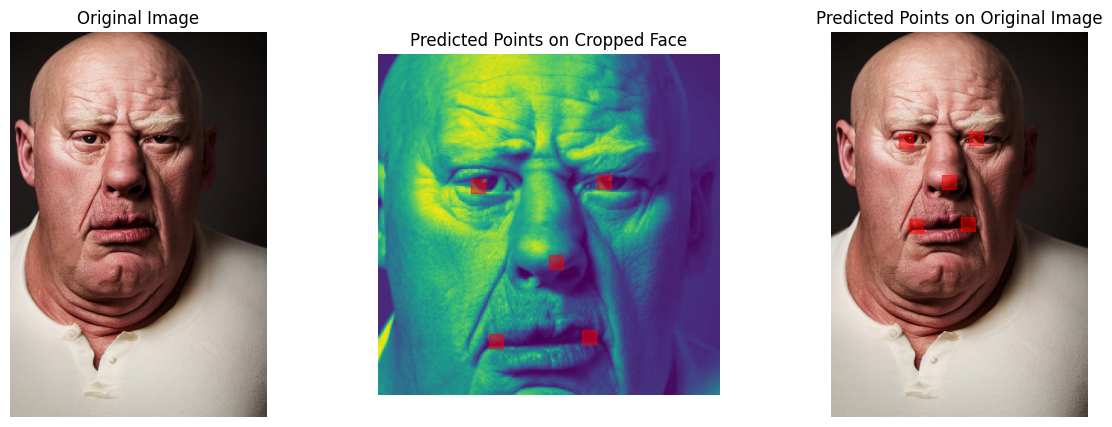

In [186]:
fin_test_pred_plot(image_path='/content/public.jpg', transform=Transforms('fin_test'), model = model.to('cpu'))

In [189]:
fin_test_pred_plot(image_path='/content/photo_2023-09-16_20-23-02.jpg', transform=Transforms('fin_test'), model = model.to('cpu'))

---Face is not detected---



'There is no face on this image.'

In [ ]:
from google.colab import files

files.download('/content/myModel1.pth')